## Assignemnt #1 - find genes with differential gene expression patterns. 

We want to find the genes that have statistically significant patterns of their gene expression levels. 

Define a measure that captures the idea of spatially varying gene expression. Think about it, there are many ways to do that. 

Hint: If expression pattern is uniform, what do you expect from two cells that are neighbors compared to cells that are not? 

Repeat your analysis taking into account cell types 


### Useful tool - KNN distances

to find if expression patterns are local you need to know which cells are the neighbors of a given cell. 
We do that with sklean package (k nearest neighbors)

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
np.random.seed(0)

mu, sigma = 10, 5
xy = np.random.normal(mu, sigma, (100, 2))


k = 5  # or any other number you prefer
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(xy)
distances, indices = nbrs.kneighbors(xy)

ModuleNotFoundError: No module named 'sklearn'

In [2]:
distances

array([[0.        , 0.10031233, 0.17354638, 0.33683095, 0.42193949],
       [0.        , 0.22299133, 0.26091184, 0.35778274, 0.61538469],
       [0.        , 1.76534673, 2.27033892, 2.37712608, 2.43643506],
       ...,
       [0.        , 0.02609462, 0.34825978, 0.38385796, 0.43303073],
       [0.        , 0.18071092, 0.69765965, 0.80616595, 0.93103888],
       [0.        , 0.20569891, 0.30451583, 0.32036085, 0.51223411]])

In [3]:
indices

array([[  0, 788, 226, 965, 336],
       [  1, 959, 614, 445, 444],
       [  2, 204, 494, 412, 746],
       ...,
       [997,  38, 953, 549, 214],
       [998, 403, 282, 831, 185],
       [999, 773, 754, 938, 118]])

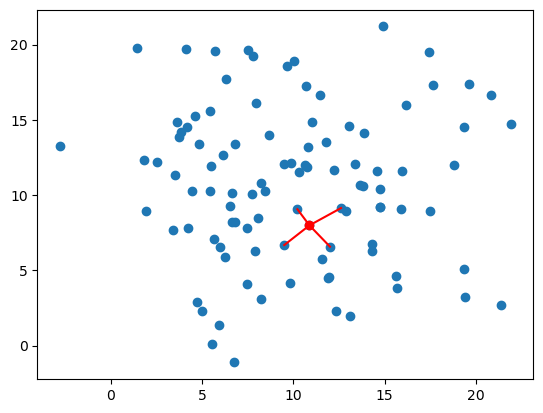

In [9]:
import matplotlib.pyplot as plt

focal_points=32

plt.scatter(xy[:, 0], xy[:, 1])
plt.scatter(xy[focal_points, 0], xy[focal_points, 1], color='red')

for i in indices[focal_points]:
    plt.plot([xy[focal_points, 0], xy[i, 0]], [xy[focal_points, 1], xy[i, 1]], 'r-')

plt.show()


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import anndata
adata = anndata.read_h5ad('../Data/Brain_AllenData.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 978067 × 550
    obs: 'brain_section_label', 'Slice', 'cluster_alias', 'average_correlation_score', 'matrix_label', 'donor_label', 'low_quality_mapping', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'node_size', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer'


In [3]:
#Downsample the cells to a subset of 10,000 random cells

slices = adata.obs['Slice'].unique().tolist()
print(slices)
random_number = np.random.randint(0, len(slices) - 1)
random_slice = slices[random_number]
print(random_slice)
sample = adata[adata.obs['Slice'] == random_slice]
print(sample)

['C57BL6J-638850.01', 'C57BL6J-638850.05', 'C57BL6J-638850.10', 'C57BL6J-638850.14', 'C57BL6J-638850.18', 'C57BL6J-638850.26', 'C57BL6J-638850.30', 'C57BL6J-638850.35', 'C57BL6J-638850.39', 'C57BL6J-638850.44', 'C57BL6J-638850.48', 'C57BL6J-638850.52', 'C57BL6J-638850.57', 'C57BL6J-638850.61', 'C57BL6J-638850.67']
C57BL6J-638850.10
View of AnnData object with n_obs × n_vars = 42563 × 550
    obs: 'brain_section_label', 'Slice', 'cluster_alias', 'average_correlation_score', 'matrix_label', 'donor_label', 'low_quality_mapping', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'node_size', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer'


In [1]:
#Look at standard deviations of gene expression levels across the sample

std_deviation = np.std(sample.X.toarray(), axis=0)

x = np.arange(len(std_deviation))  # Create an array of indices
y = std_deviation  # Your array values

plt.figure(figsize=(10, 6))
plt.bar(x, y, width=2.5)
plt.xlabel('Gene Number')
plt.ylabel('Std Deviation of Gene Expression')
plt.show()

NameError: name 'np' is not defined

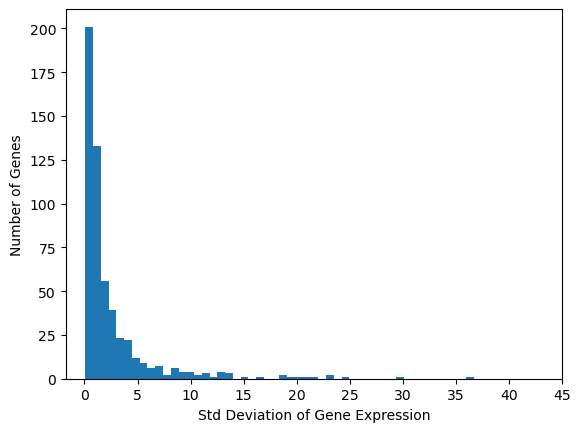

In [5]:
#Plot a histogram of the standard deviations
plt.hist(std_deviation, bins=50)  # Adjust the number of bins as needed
plt.xticks(np.arange(0, 50, 5))
plt.xlabel('Std Deviation of Gene Expression')
plt.ylabel('Number of Genes')
plt.show()

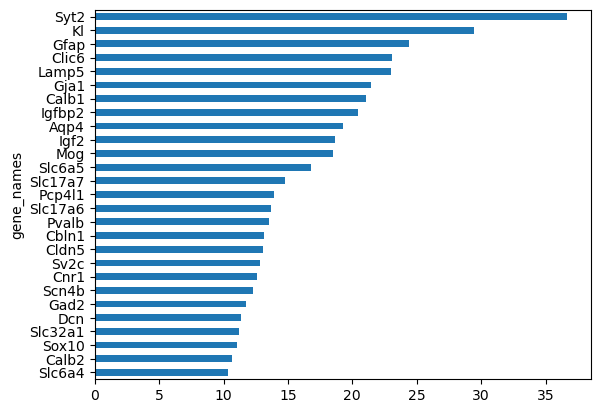

In [6]:
#Make a list of the genes with a significant variance (std dev > 10)
df = pd.DataFrame({
    'gene_names': sample.var['gene_symbol'],
    'std_deviation': std_deviation    
})

df = df.sort_values('std_deviation', ascending=False)

dftop = df[df['std_deviation'] > 10]

fig, ax = plt.subplots()
dftop.plot(kind='barh', x='gene_names', y='std_deviation', ax=ax)
ax.invert_yaxis()
ax.legend().remove()
plt.show()

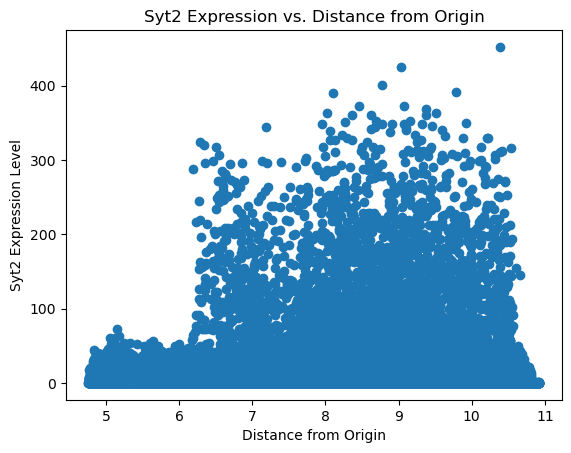

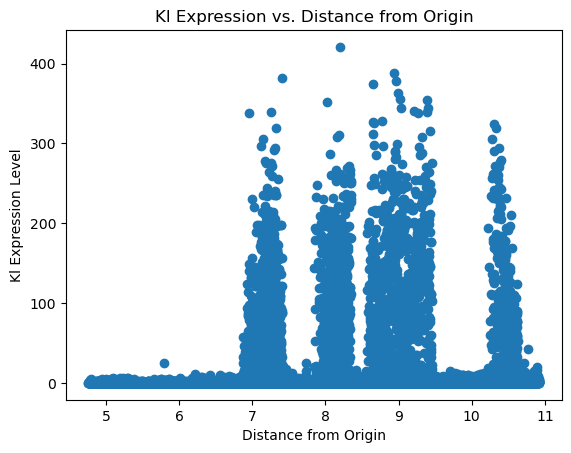

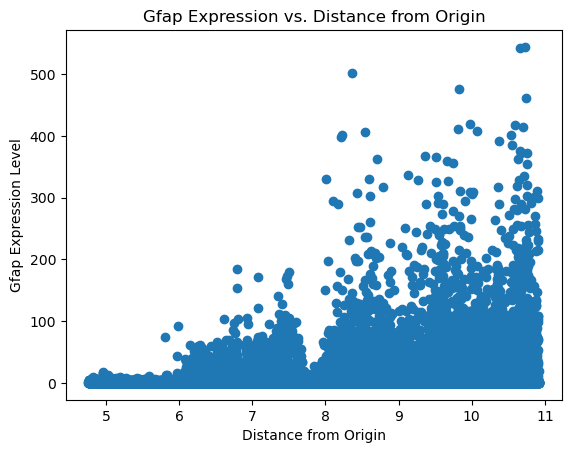

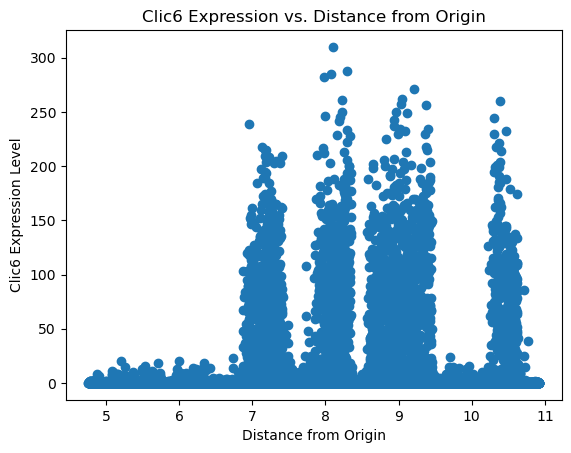

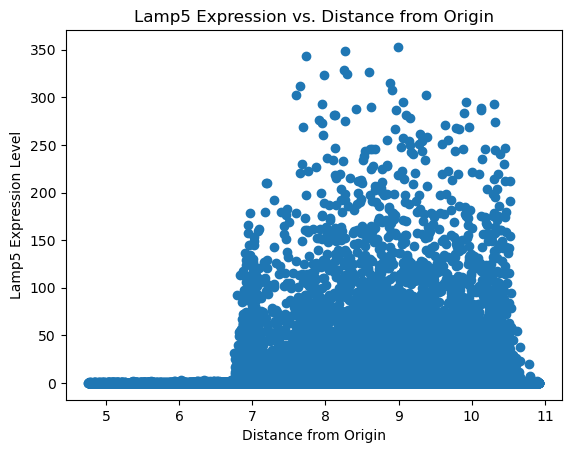

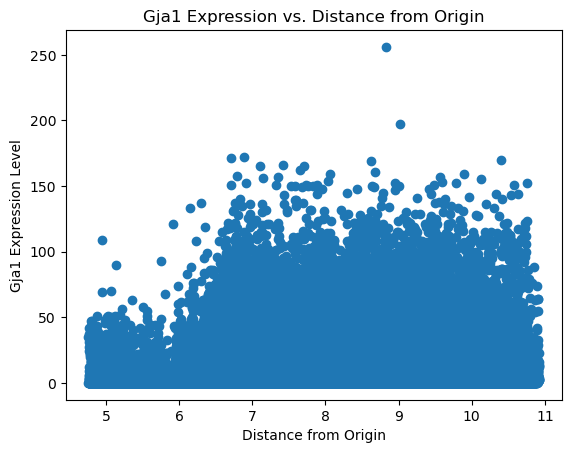

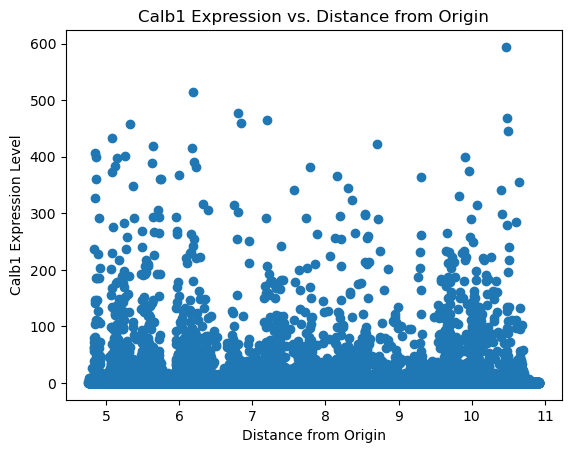

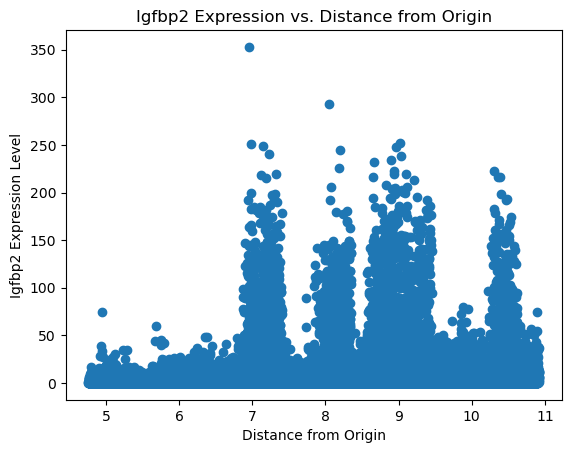

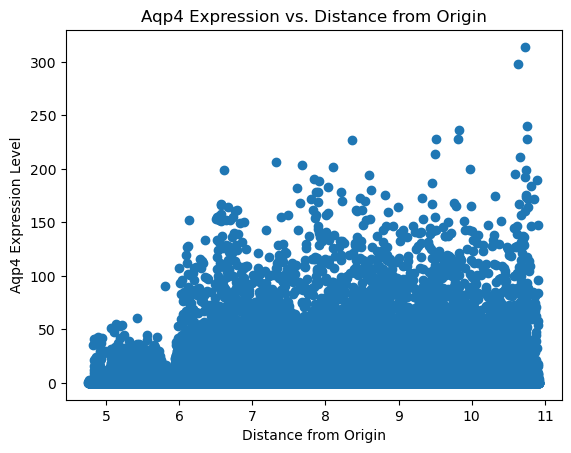

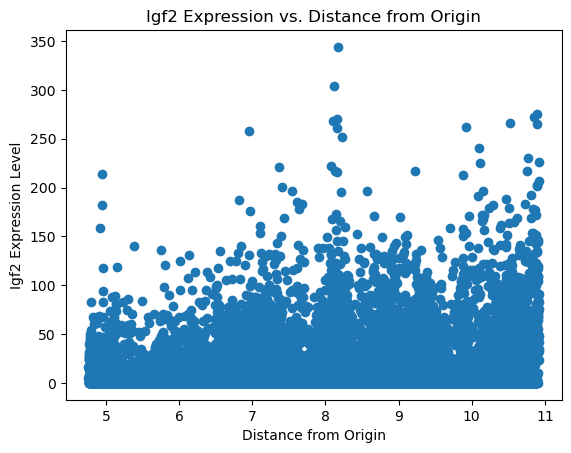

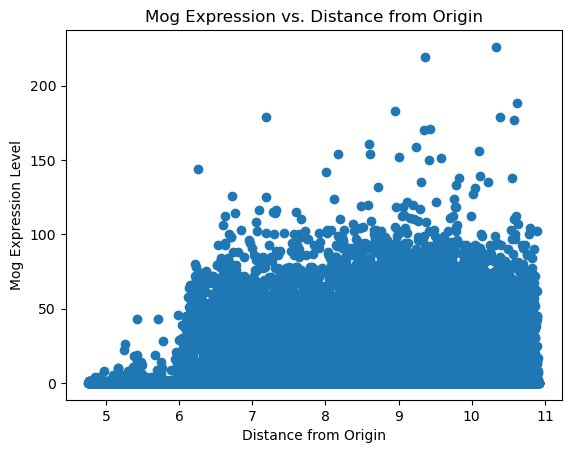

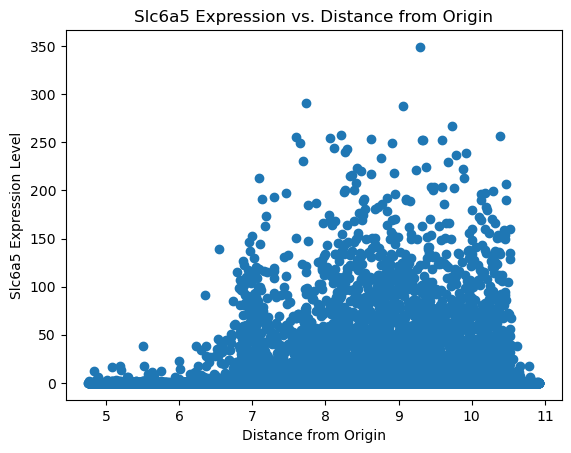

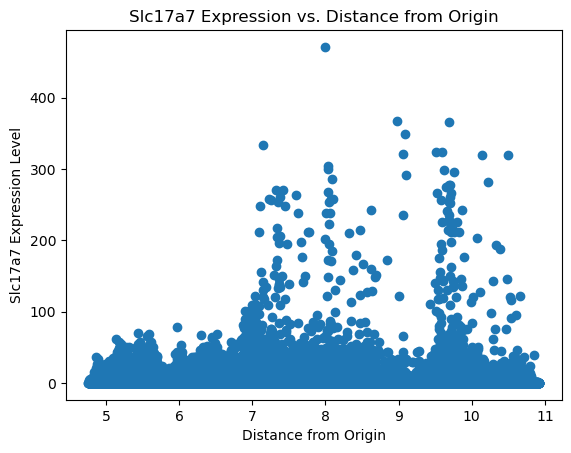

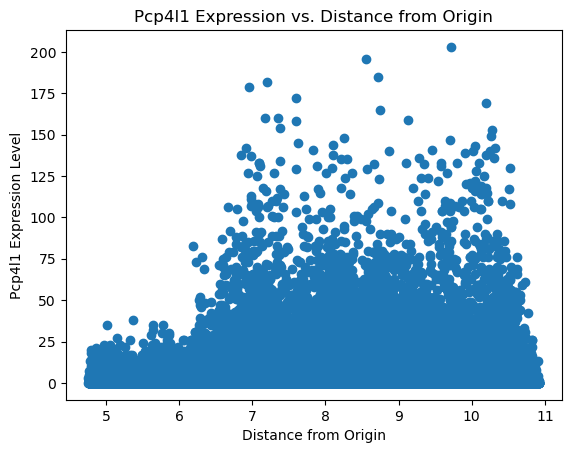

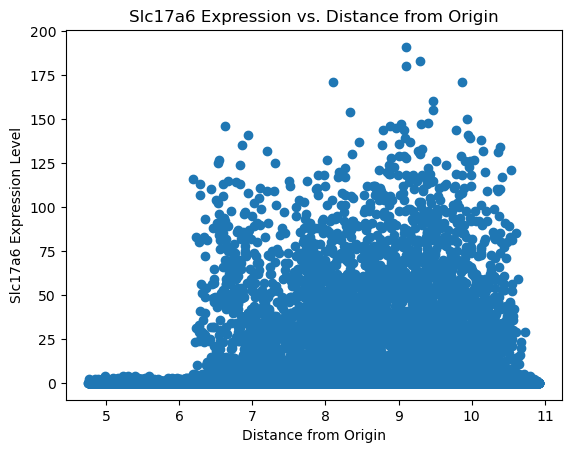

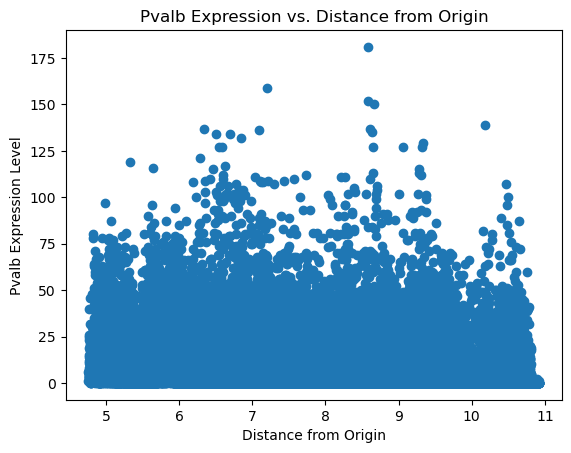

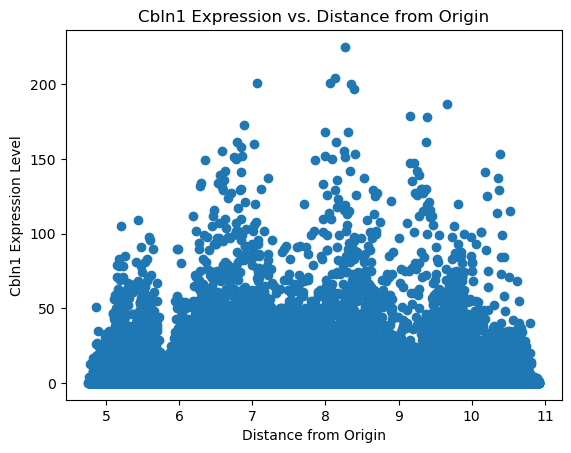

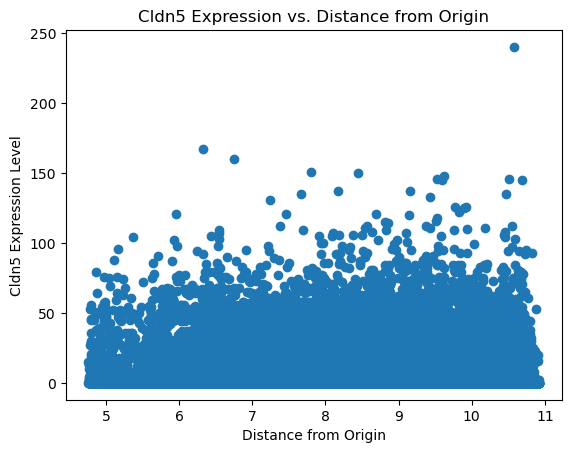

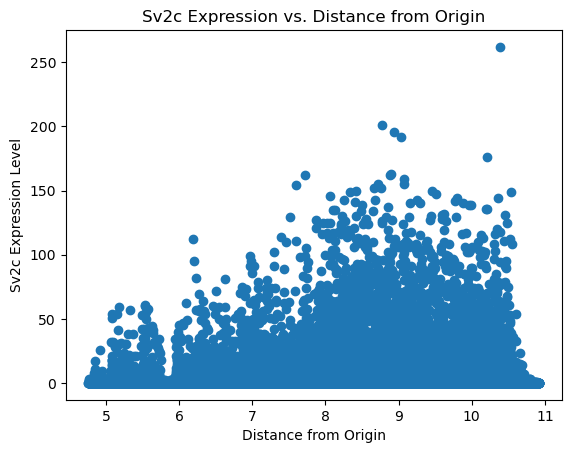

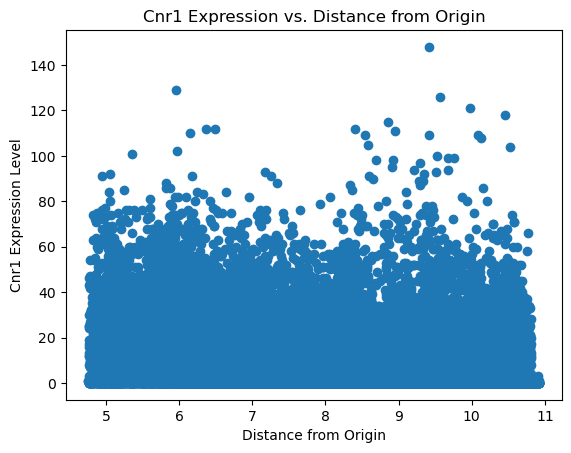

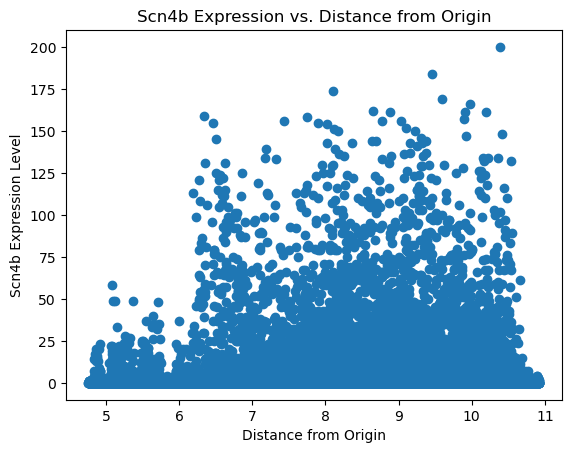

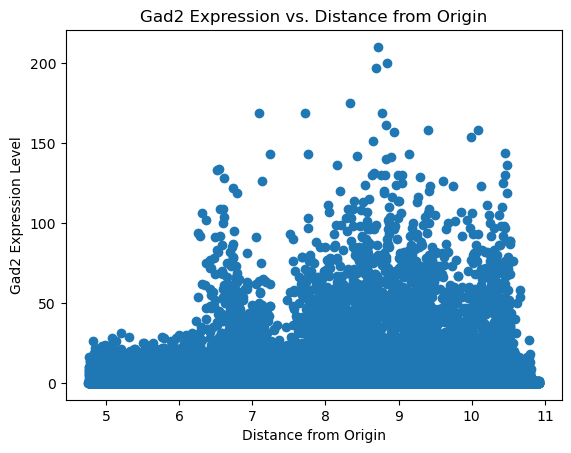

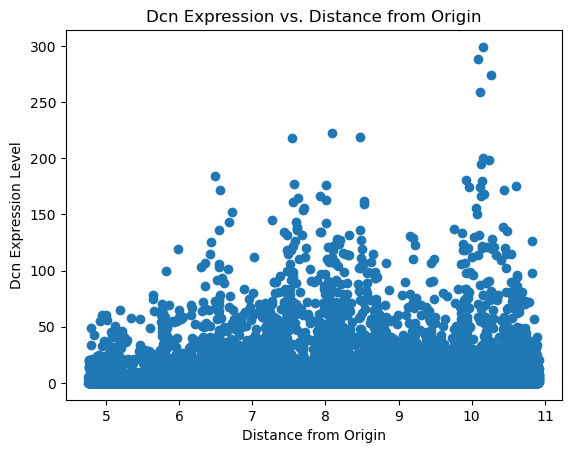

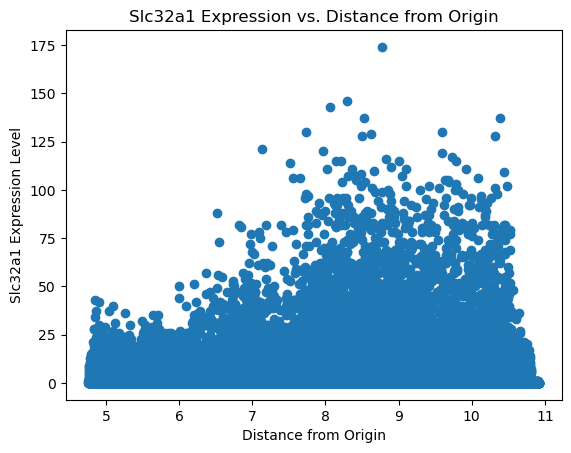

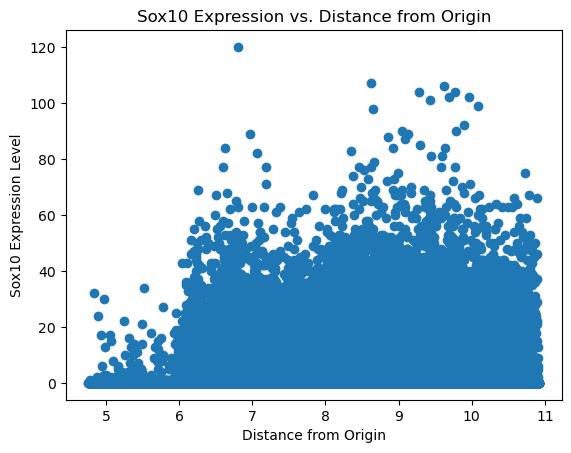

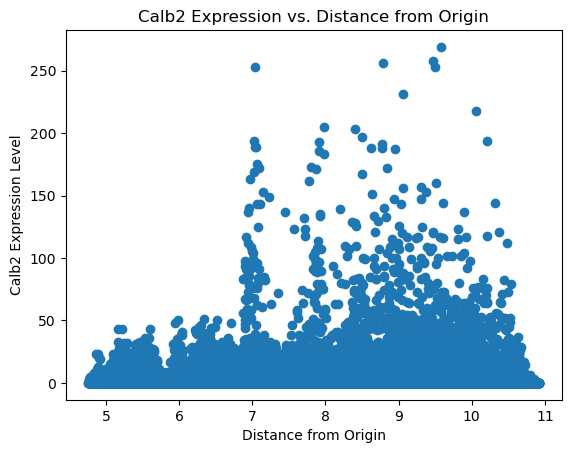

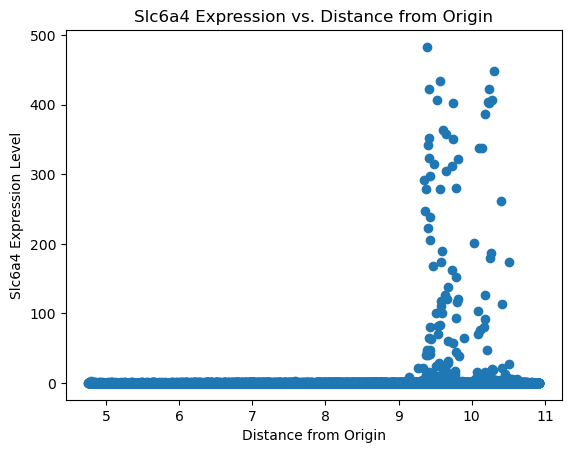

In [7]:
# Assuming 'x', 'y', and 'z' are column names in sample.obs for the spatial coordinates
coordinates = sample.obs[['x', 'y', 'z']]

# Calculate the squared distance from (0, 0, 0) for each cell
squared_distances = np.sum(np.square(coordinates), axis=1)

# Take the square root to get the Euclidean distance
distances = np.sqrt(squared_distances)


# Step 1: Identify the column index of the gene

for index, row in dftop.iterrows():
    # Now you can access data in 'row' using column names
    # For example, to get the gene name and its standard deviation:
    gene_name = row['gene_names']
    gene_index = np.where(sample.var['gene_symbol'] == gene_name)[0]

    # Step 2: Extract the expression data for this gene
    gene_expression = sample.X[:, gene_index].toarray().flatten()

    plt.scatter(distances, gene_expression)
    plt.xlabel('Distance from Origin')
    plt.ylabel(gene_name + ' Expression Level')
    plt.title(gene_name + ' Expression vs. Distance from Origin')
    plt.show()

Plot x and y values of slice with the color of scatter plot points signifying gene expression.

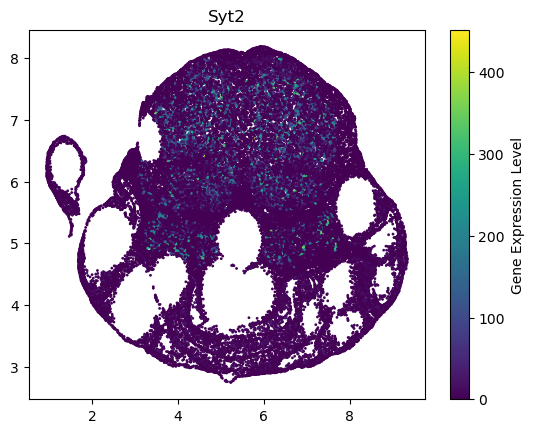

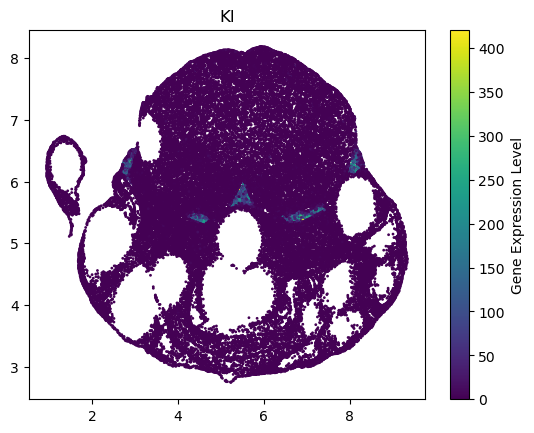

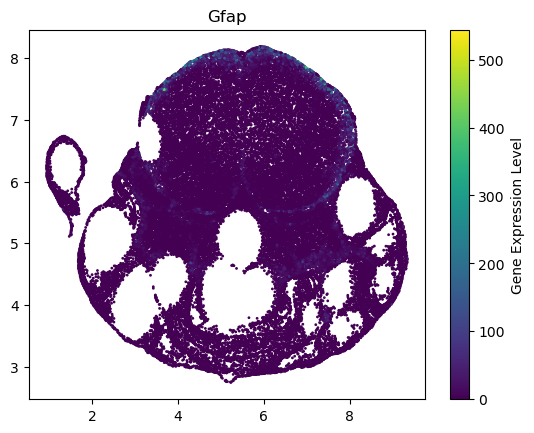

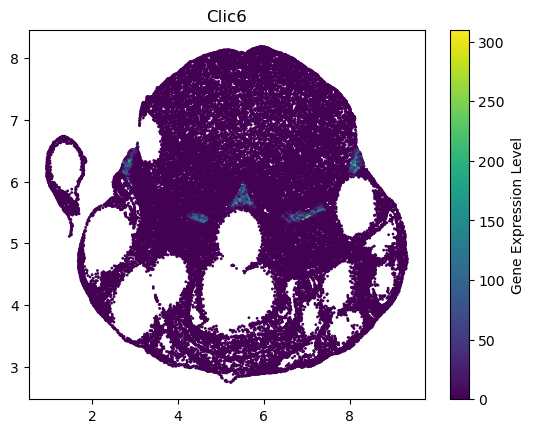

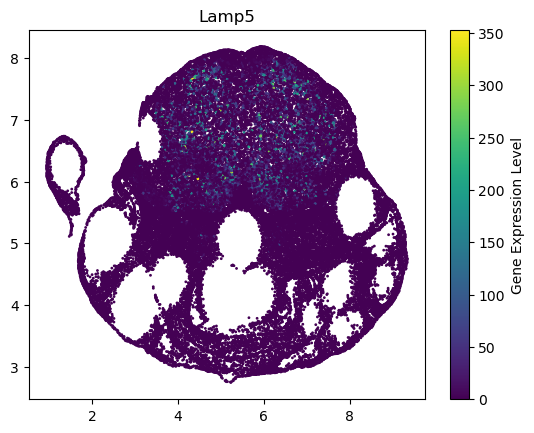

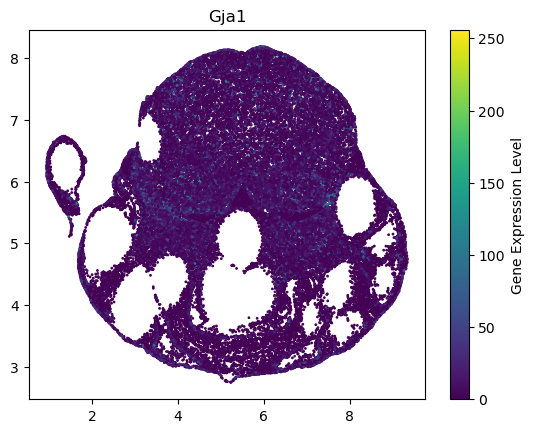

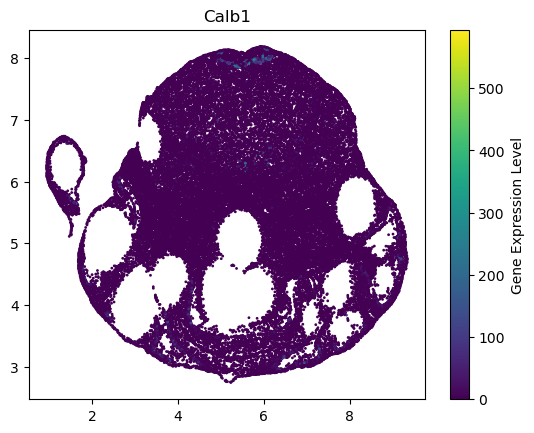

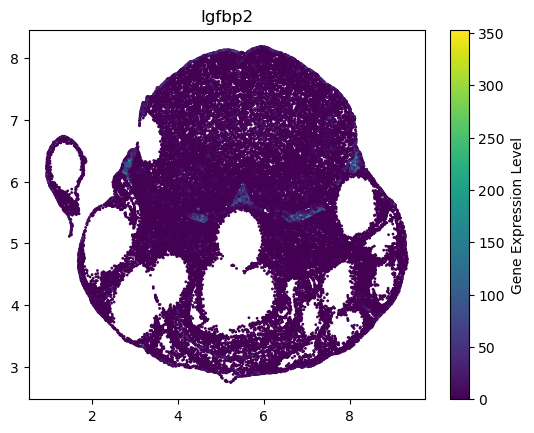

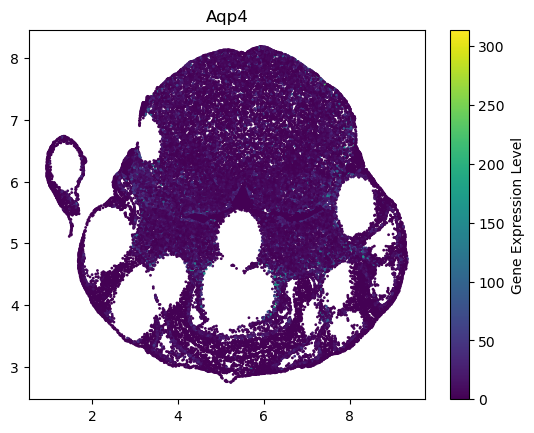

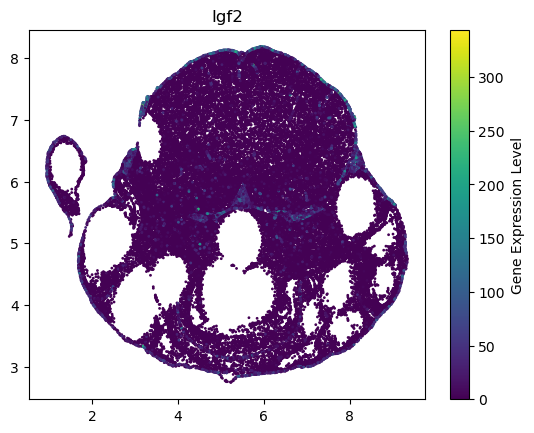

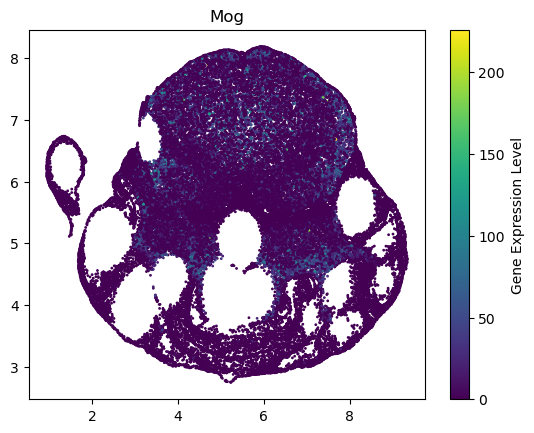

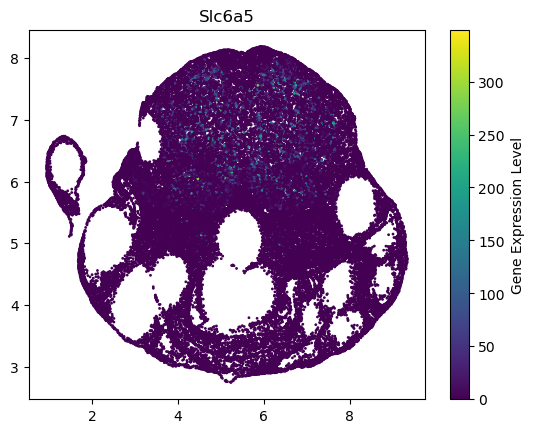

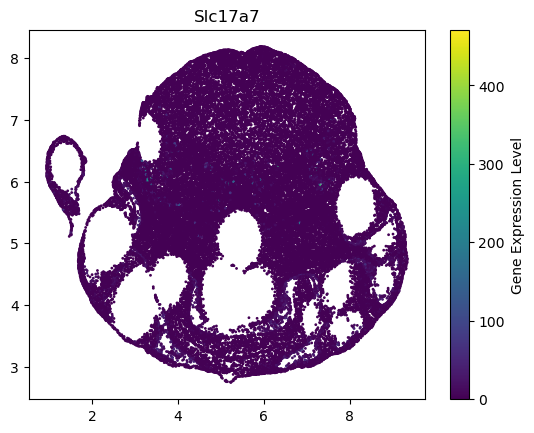

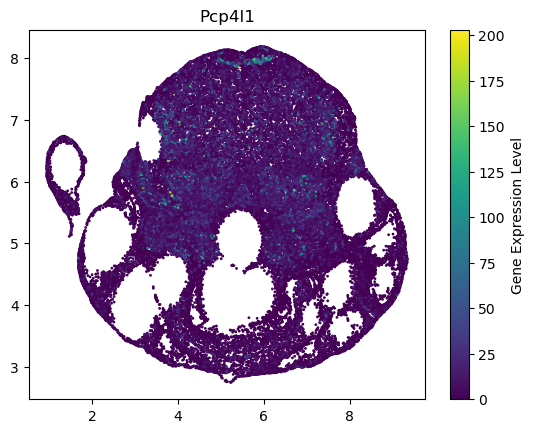

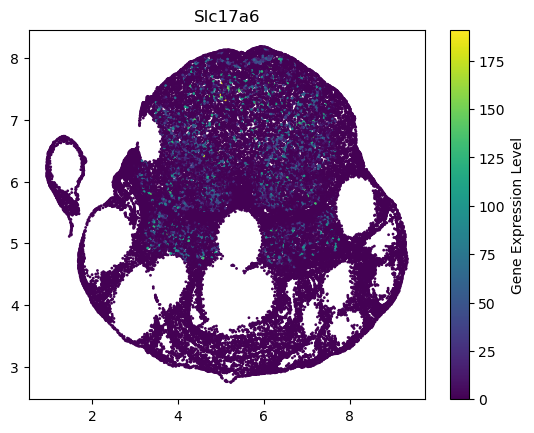

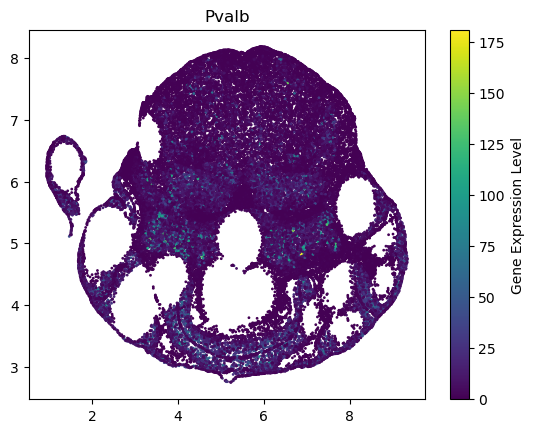

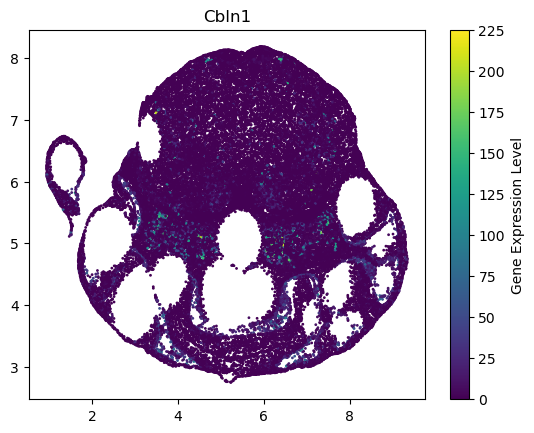

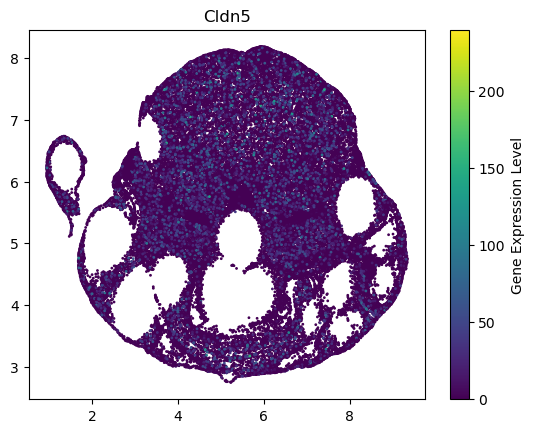

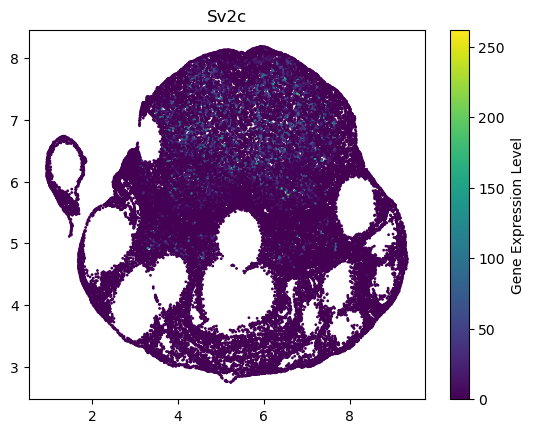

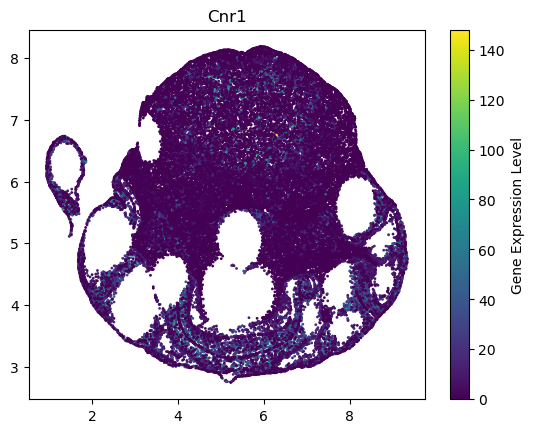

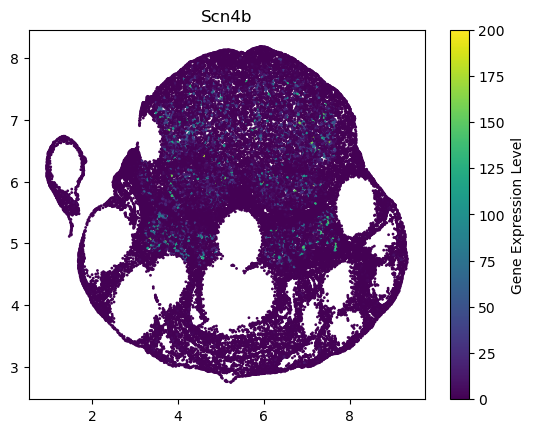

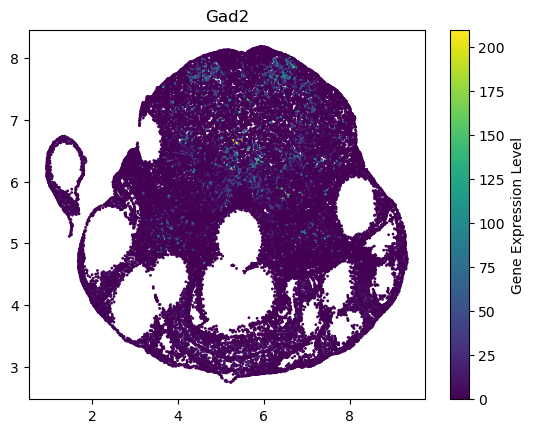

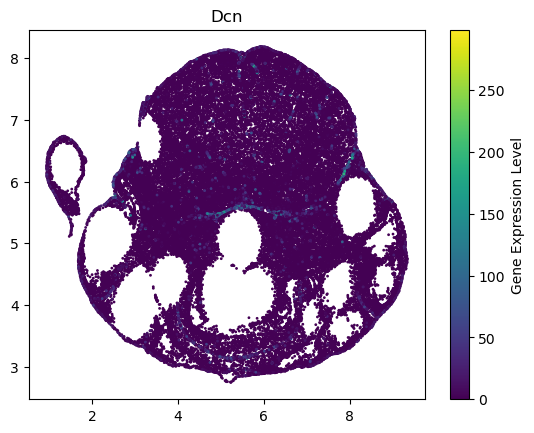

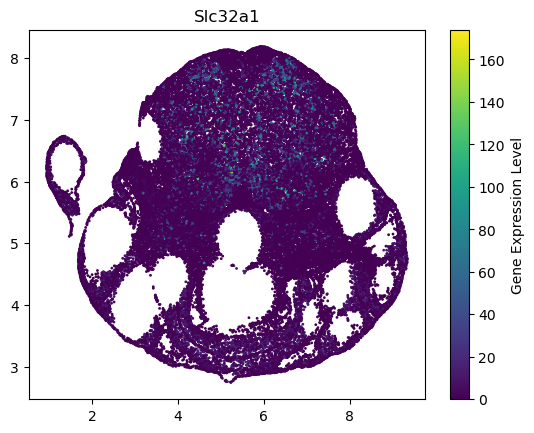

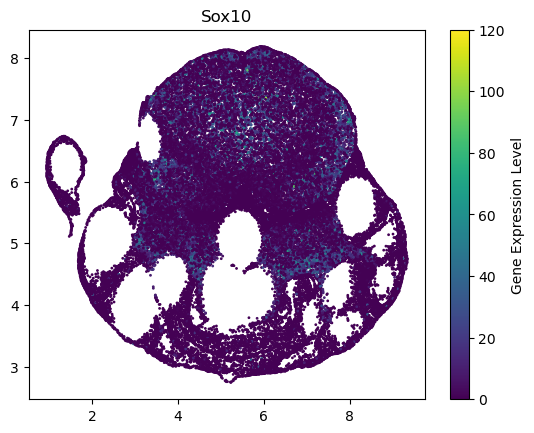

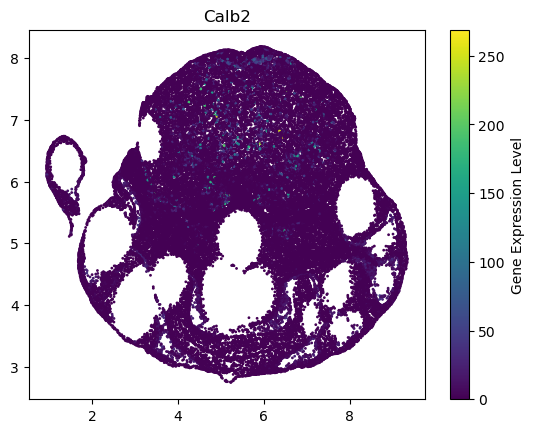

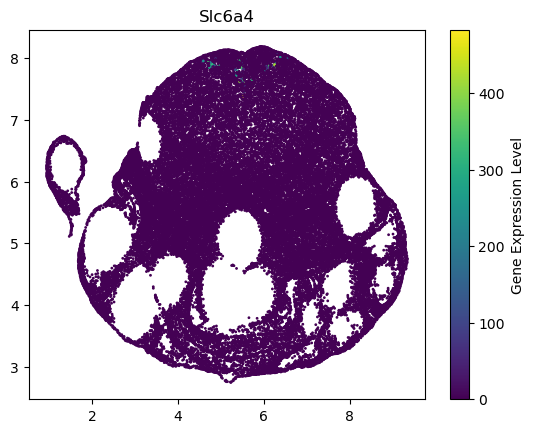

In [8]:
# Assuming 'x', 'y', and 'z' are column names in sample.obs for the spatial coordinates
x_coordinates = sample.obs[['x']]
y_coordinates = sample.obs[['y']]

# Calculate the squared distance from (0, 0, 0) for each cell
squared_distances = np.sum(np.square(coordinates), axis=1)

# Take the square root to get the Euclidean distance
distances = np.sqrt(squared_distances)


# Step 1: Identify the column index of the gene

for index, row in dftop.iterrows():
    # Now you can access data in 'row' using column names
    # For example, to get the gene name and its standard deviation:
    gene_name = row['gene_names']
    gene_index = np.where(sample.var['gene_symbol'] == gene_name)[0]
  
      # Step 2: Extract the expression data for this gene
    gene_expression = sample.X[:, gene_index].toarray().flatten()

    plt.scatter(x_coordinates, y_coordinates, c=gene_expression, cmap='viridis', s=1)
    plt.colorbar(label='Gene Expression Level')
    plt.title(gene_name)
    plt.show()

Need to define a measure to represent spatially varying gene expression

In [28]:
from sklearn.neighbors import NearestNeighbors

from scipy.sparse import issparse

# Convert the expression matrix to a dense format if it's sparse
X_dense = sample.X.toarray() if issparse(sample.X) else sample.X

# Step 1: Prepare the spatial coordinates data
coordinates = sample.obs[['x', 'y']]  # Use ['x', 'y', 'z'] for 3D data

# Step 2: Fit the NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coordinates)

for index, row in dftop.iterrows():
    # Now you can access data in 'row' using column names
    # For example, to get the gene name and its standard deviation:
    gene_name = row['gene_names']
    gene_index = np.where(sample.var['gene_symbol'] == gene_name)[0]
  
    #Step 3: Extract the expression data for this gene
    gene_expression = sample.X[:, gene_index].toarray().flatten()

    #Step 4: Find the highest gene expression
    max_expression_index = np.argmax(gene_expression)
    max_expression_value = gene_expression[max_expression_index]

    # Step 5: Retrieve the coordinates of the cell of interest
    cell_coordinates = coordinates.iloc[max_expression_index].values.reshape(1, -1)  # Reshape is necessary for a single sample

    # Step 6: Find the nearest neighbors (excluding the first one as it is the cell itself)
    distances, indices = nbrs.kneighbors(cell_coordinates)

    # Step 7: Access the nearest neighbors' information
    nearest_neighbors_info = sample.obs.iloc[indices[0][1:]]  # Skipping the first index as it is the cell itself

    # Calculate the average gene expression level for the nearest neighbors
    gene_expression_neighbors = gene_expression[indices]
    avg_expression_neighbors = np.mean(gene_expression_neighbors)

    # Calculate the average gene expression level for all cells
    avg_expression_all = np.mean(gene_expression)

    # Prepare the DataFrame
    data = {
        'Group': ['Nearest Neighbors'] * len(avg_expression_neighbors) + ['All Cells'] * len(avg_expression_all),
        'Average Expression': np.concatenate([avg_expression_neighbors, avg_expression_all])
    }
    df = pd.DataFrame(data)

    # Create the violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Group', y='Average Expression', data=df)
    plt.title('Comparison of Average Gene Expression')
    plt.ylabel('Average Expression Level')
    plt.xlabel('Group')
    plt.show()


c:\Users\Nicole\.conda\envs\physci200\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


TypeError: object of type 'numpy.float32' has no len()